# Generowanie tekstu 

Projekt wykorzysta tekst Pana Tadeusza autorstwa Adama Mickiewicza z domeny publicznej: https://wolnelektury.pl/media/book/txt/pan-tadeusz.txt. Wykorzystamy ten tekst to generowania tekstu.

Przyjmiemy dwa podejścia:
- wygenerujemy tekst po znakach 
- wygenerujemy tekst po słowach

używając LSTM. 

W pierwszym przypadku sieć będzie korzystała z wąskiego słownika wejściowego i decyzji. W drugim przypadku słownik możliwych słów będzie duży, ale pewne kroki zostaną pominięte np.: generowanie słów z liter.

Porównamy wyniki, opiszemy zauważone rezultaty i wyciągniemy wnioski z projektu. Jednocześnie zaprezentujemy teksty, jakie zostały wygenerowane przez sieć.

Pierwsze zaimportujmy niezbędne Pythonowe moduły:

In [1]:
import keras.utils.np_utils as np_utils
import tensorflow as tf
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras import Input
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding

import numpy as np
import pandas as pd

import glob 
import random
import io
import unidecode
import codecs

W folderze data znajdują się pliki z nazwami wykonawców, a w środku takich plików są teksty śpiewane.

In [2]:
def get_corpus(max_len=20000):
    paths = glob.glob("data_pl\\*.txt")
    raw_corpus = ""

    for file in paths:
        print(file)
        with codecs.open(file,'r',"utf-8") as f:
            raw_corpus += f.read()
        if len(raw_corpus) >= max_len:
            break
            
    return raw_corpus[:max_len]

raw_corpus = get_corpus()
print(raw_corpus)

data_pl\pan_tadeusz.txt
Adam Mickiewicz

Pan Tadeusz czyli ostatni zajazd na Litwie

Księga pierwsza

Gospodarstwo

Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy

    Litwo! Ojczyzno moja! ty jesteś jak zdrowie:
Ile cię trzeba cenić, ten tylko się dowie,
Kto cię stracił. Dziś piękność twą w całej ozdobie
Widzę i opisuję, bo tęsknię po tobie.

    Panno święta, co Jasnej bronisz Częstochowy
I w Ostrej świecisz Bramie! Ty, co gród zamkowy
Nowogródzki ochraniasz z jego wiernym ludem!
Jak mnie dziecko do zdrowia powróciłaś cudem
(Gdy od płaczącej matki, pod Twoją opiekę
Ofiarowany, martwą podniosłem powiekę;
I zaraz mogłem pieszo, do Twych świątyń progu
Iść za wrócone życie podziękować Bogu),
Tak nas powrócisz cudem na Ojczyzny łono.
Tymczasem przenoś moją duszę

Przetwórzmy dane: odfiltrujmy wszystkie niewłaściwe znaki i zdekodujmy znaki unicode na odpowiedniki ASCII.

In [3]:
raw_corpus = ''.join([i for i in raw_corpus if i.isalpha() or i in [' ','\n','\r']]) 
raw_corpus = unidecode.unidecode(raw_corpus)
#raw_corpus = raw_corpus.lower()
    
print(raw_corpus)

Adam Mickiewicz

Pan Tadeusz czyli ostatni zajazd na Litwie

Ksiega pierwsza

Gospodarstwo

Powrot panicza  Spotkanie sie pierwsze w pokoiku drugie u stolu  Wazna Sedziego nauka o grzecznosci  Podkomorzego uwagi polityczne nad modami  Poczatek sporu o Kusego i Sokola  Zale Wojskiego  Ostatni Wozny Trybunalu  Rzut oka na owczesny stan polityczny Litwy i Europy

    Litwo Ojczyzno moja ty jestes jak zdrowie
Ile cie trzeba cenic ten tylko sie dowie
Kto cie stracil Dzis pieknosc twa w calej ozdobie
Widze i opisuje bo tesknie po tobie

    Panno swieta co Jasnej bronisz Czestochowy
I w Ostrej swiecisz Bramie Ty co grod zamkowy
Nowogrodzki ochraniasz z jego wiernym ludem
Jak mnie dziecko do zdrowia powrocilas cudem
Gdy od placzacej matki pod Twoja opieke
Ofiarowany martwa podnioslem powieke
I zaraz moglem pieszo do Twych swiatyn progu
Isc za wrocone zycie podziekowac Bogu
Tak nas powrocisz cudem na Ojczyzny lono
Tymczasem przenos moja dusze uteskniona
Do tych pagorkow lesnych do tych lak zie

Zdefiniujmy funkcję, która generuje słownik z naszego corpusu danych. Taki słownik zmienia nam litery na inty, które będą nam odpowiednio aktywowały i-ty neuron na wejściu.

In [4]:
def get_symbol_dict(corpus=raw_corpus) -> dict:
    #get all set of used symbols
    symbols = set()
    for element in corpus:
        symbols.add(element)
    #create dictionary for symbols
    symbols = sorted(symbols)
    symbol_to_int = dict((p, id) for id, p in enumerate(symbols))

    return symbol_to_int

In [5]:
s_dict = get_symbol_dict()
s_dict

{'\n': 0,
 '\r': 1,
 ' ': 2,
 'A': 3,
 'B': 4,
 'C': 5,
 'D': 6,
 'E': 7,
 'F': 8,
 'G': 9,
 'H': 10,
 'I': 11,
 'J': 12,
 'K': 13,
 'L': 14,
 'M': 15,
 'N': 16,
 'O': 17,
 'P': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'W': 23,
 'Z': 24,
 'a': 25,
 'b': 26,
 'c': 27,
 'd': 28,
 'e': 29,
 'f': 30,
 'g': 31,
 'h': 32,
 'i': 33,
 'j': 34,
 'k': 35,
 'l': 36,
 'm': 37,
 'n': 38,
 'o': 39,
 'p': 40,
 'r': 41,
 's': 42,
 't': 43,
 'u': 44,
 'w': 45,
 'y': 46,
 'z': 47}

Zdefiniujmy stałe:
- długość sekwencji uwzględnianych dla LSTM
- długość sekwencji w predykcji
- rozmiar batch'a
- ile epok bedziemy szkolili nasze sieci

Ponadto funkcje
- translate - do zmiany sekwencji w z liter/słów na inty i vice versa przy użyciu wygenerowanego słownika
- sample - pomocnicza funkcja, która pozwala lepiej próbkować predykcje, unikniemy w pewnym stopniu overfittingu
- predict - do wykonywania predykcji sekwencji z modelu
- process_to_sequential - która zmieni nam corpus w sekwencje do nauki: "a b c d" -> x = [[a b], [b,c]], y = [[c] [d]]

In [6]:
SEQ_LEN = 20
P_SEQ_LEN = 1

BATCH_SIZE = 32
EPOCHS = 25

def translate(sequence, translate_dict:dict, reverse=False) -> list:
    
    if reverse==True:
        translate_dict = dict({v: k for k, v in translate_dict.items()})

    translated = []
    for c in sequence:
        try:
            translated.append(translate_dict[c])
        except Exception as e:
            pass
            
    return translated

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def predict(model, s_dict, start_pattern, max_p_len = 400, temperature=1.0, sep='', seq_len=SEQ_LEN) -> str:
        while len(start_pattern) < seq_len:
            start_pattern = " " + start_pattern
        
        pattern = translate(start_pattern,s_dict)
        prediction_output = []
        
        for note_index in range(max_p_len):
            prediction_input = np.reshape(pattern, (1, len(pattern), 1))

            prediction = model.predict(prediction_input, verbose=0)[0]    

            index = sample(prediction,temperature)
            result = index

            prediction_output.append(result)    

            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]
        
        out = translate(prediction_output,s_dict,True)
        out = sep.join(out)

        return out
    
def process_to_sequential(data, past_steps=SEQ_LEN, future_steps=P_SEQ_LEN,):
    x, y = [], []
    for i in range(0, len(data) - past_steps - future_steps + 1):
        x.append(data[i:(i+past_steps)])
        y.append(data[(i+past_steps):(i + past_steps + future_steps)])
    return np.array(x), np.array(y)

Zróbmy jeszcze funkcję do generowania modelu. Będziemy jej używali chcąc porównać wyniki dobierania odpowiednich parametrów w naszym projekcie.

In [7]:
def get_lstm_model(input_shape, output_len, units = 256, dropout = 0.2) -> Sequential:
    model = Sequential()
    model.add(Embedding(output_len, 128, input_length=input_shape[1]))
    model.add(LSTM(units, input_shape=(input_shape[1], input_shape[2]),return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(output_len, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

# Generowanie tekstu po literach

Pierwsze przetłumaczmy nasz corpus wejściowy na inty ze wcześniej wygenerowanego słownika.

In [8]:
translated_corpus = translate(raw_corpus,s_dict)
print(translated_corpus)

[3, 28, 25, 37, 2, 15, 33, 27, 35, 33, 29, 45, 33, 27, 47, 1, 0, 1, 0, 18, 25, 38, 2, 21, 25, 28, 29, 44, 42, 47, 2, 27, 47, 46, 36, 33, 2, 39, 42, 43, 25, 43, 38, 33, 2, 47, 25, 34, 25, 47, 28, 2, 38, 25, 2, 14, 33, 43, 45, 33, 29, 1, 0, 1, 0, 13, 42, 33, 29, 31, 25, 2, 40, 33, 29, 41, 45, 42, 47, 25, 1, 0, 1, 0, 9, 39, 42, 40, 39, 28, 25, 41, 42, 43, 45, 39, 1, 0, 1, 0, 18, 39, 45, 41, 39, 43, 2, 40, 25, 38, 33, 27, 47, 25, 2, 2, 20, 40, 39, 43, 35, 25, 38, 33, 29, 2, 42, 33, 29, 2, 40, 33, 29, 41, 45, 42, 47, 29, 2, 45, 2, 40, 39, 35, 39, 33, 35, 44, 2, 28, 41, 44, 31, 33, 29, 2, 44, 2, 42, 43, 39, 36, 44, 2, 2, 23, 25, 47, 38, 25, 2, 20, 29, 28, 47, 33, 29, 31, 39, 2, 38, 25, 44, 35, 25, 2, 39, 2, 31, 41, 47, 29, 27, 47, 38, 39, 42, 27, 33, 2, 2, 18, 39, 28, 35, 39, 37, 39, 41, 47, 29, 31, 39, 2, 44, 45, 25, 31, 33, 2, 40, 39, 36, 33, 43, 46, 27, 47, 38, 29, 2, 38, 25, 28, 2, 37, 39, 28, 25, 37, 33, 2, 2, 18, 39, 27, 47, 25, 43, 29, 35, 2, 42, 40, 39, 41, 44, 2, 39, 2, 13, 44, 42, 

Teraz z tego ciągu intów wyróżnijmy sekwencje wejściowe i wyjściowe do nauki predykcji.

Odpowiednio jeszcze przekształćmy dane by pasowały do naszego modelu.

In [9]:
net_in,net_out = process_to_sequential(translated_corpus)

net_in = np.reshape(net_in, (len(net_in),SEQ_LEN,1))

net_in[0]

array([[ 3],
       [28],
       [25],
       [37],
       [ 2],
       [15],
       [33],
       [27],
       [35],
       [33],
       [29],
       [45],
       [33],
       [27],
       [47],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [18]])

In [10]:
net_out = np_utils.to_categorical(net_out)

net_out[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Weźmy teraz nasz model i nauczmy go na naszych net_in i net_out. Póki co szkolimy go na małych danych i bardzo krótko.

In [11]:
model_1 = get_lstm_model(net_in.shape,len(s_dict))
model_1.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/25
604/604 [==============================] - 37s 20ms/step - loss: 3.1426 - accuracy: 0.1390
Epoch 2/25
604/604 [==============================] - 12s 20ms/step - loss: 2.4028 - accuracy: 0.2668
Epoch 3/25
604/604 [==============================] - 12s 20ms/step - loss: 2.2307 - accuracy: 0.3044
Epoch 4/25
604/604 [==============================] - 12s 20ms/step - loss: 2.0849 - accuracy: 0.3460
Epoch 5/25
604/604 [==============================] - 12s 20ms/step - loss: 1.9610 - accuracy: 0.38200s - loss: 1.9612 - 
Epoch 6/25
604/604 [==============================] - 12s 19ms/step - loss: 1.8064 - accuracy: 0.4286
Epoch 7/25
604/604 [==============================] - 12s 19ms/step - loss: 1.7015 - accuracy: 0.4619
Epoch 8/25
604/604 [==============================] - 12s 20ms/step - loss: 1.5858 - accuracy: 0.4967
Epoch 9/25
604/604 [==============================] - 12s 19ms/step - loss: 1.4527 - accuracy: 0.5412
Epoch 10/25
604/604 [==============================] - 12s 19m

In [12]:
print(predict(model_1, s_dict, "Litwo Ojczyzno moja", max_p_len=1000))

 ty ce pechyrma zdobytach gosci
Musim bo mu wychowal po krokowac zachuszci przed ganek
Wyszadl z powusza uprzejmie scianych
Nawogolka w domu nie mogl
Ja przyszla dalej towiek
Bo nie puste bo on je nas poreczu i z usknie ubialo
Blosc ze wyszal przypadli
Starod mloniego nie mowil
I sieniona na krzeki na to kazny hojej wyjadla
Pogrzyczno niewielkim we brzezowym gazde gorzac
Gosciany przysie na samotnej lace
Wes cie zadam ze okania
Pan Wojski dofyknie urodzic
Wo Sedziego nawielskim dzieciel czeladzi
Tak moglby spojac przed nim lezych gosci
W zamku wypol ktory obyczaje
Wtenczas i swoja waznosc zarazem poznajej sie drzwiczki
Nigdy milon ze brzychnaszyc tywace stochowy
Skinal na Todkomorzanki
Niezgorsze i przystolach zamknychoo Zeslich
Go drowny Hrzakl ciestym jedno domyslal bokowa
Przyszla nagle na samotnej lace
Srobia jego puraca gosroby a czesto bez szlacheckim w przed najalow i lebki ale jak swiecami zjacial sie rodzilo
Grzadki poscia sie polrzyczny
Byle na szancac


# Generowanie tekstu po słowach

W tym przypadku musimy pierwsze sprytnie podzielić nasz corpus by zachować '\n'. Cały proces przebiega analogicznie do poprzedniego przypadku.

In [13]:
def newline_split(text):
    lines = text.split('\n')
    splitted = []
    for line in lines:
        split_line = line.split()
        split_line.append('\n')
        for i in split_line: 
            splitted.append(i)
        
    return splitted

Teksty kreatywne mają to do siebie, że potrafią zawierać wyrazy, które występują bardzo rzadko. Może to nam zwiększyć słownik o wiele słów występujących po kilka razy w całym corpusie. Dlatego będziemy brali tylko pewną liczbę najczęściej występujących słów, a "rzadkie słowa" będą zastępywane znakiem gwiazdki. 

Zmodyfikujmy zatem get_symbol_dict by mógł operować na wyrazach.

In [14]:
from collections import Counter

def get_symbol_dict(corpus=raw_corpus, mode='letters', top=300) -> dict:
    #get all set of used symbols
    symbols = set()
    
    if mode == 'words':
        corpus_as_words = newline_split(corpus)
        word_freq = Counter(corpus_as_words).most_common()[:top]
        word_freq = dict(word_freq)
        word_freq["\n"] = 1
        word_freq["*"] = 2
        symbol_to_int = dict((p[0], id) for id, p in enumerate(word_freq.items()))

        return symbol_to_int
    
    for element in corpus:
        symbols.add(element)
    #create dictionary for symbols
    symbols = sorted(symbols)
    symbol_to_int = dict((p, id) for id, p in enumerate(symbols))

    return symbol_to_int


Tutaj będzie istotna zmiana co do poprzedniego przypadku.

Corpus danych bedzie zmodyfikowany poprzez usuniecie z niego "rzadkich słów" i zastąpienie ich gwiazdką.

Dodatkowo: zmniejszmy litery wielkie na małe by zredukować duplikaty wyrazów

In [15]:
raw_corpus = raw_corpus.lower()

s_dict = get_symbol_dict(corpus=raw_corpus, mode='words')

prepared_corpus = newline_split(raw_corpus)
#print(prepared_corpus)
crossout = []
for i in prepared_corpus:
    if i in s_dict.keys():
        crossout.append(i)
    else:
        crossout.append("*")
        
s_dict

{'\n': 0,
 'i': 1,
 'w': 2,
 'z': 3,
 'na': 4,
 'nie': 5,
 'sie': 6,
 'do': 7,
 'ze': 8,
 'jak': 9,
 'bo': 10,
 'a': 11,
 'po': 12,
 'sedzia': 13,
 'pan': 14,
 'od': 15,
 'domu': 16,
 'co': 17,
 'nim': 18,
 'juz': 19,
 'tak': 20,
 'lecz': 21,
 'to': 22,
 'gdy': 23,
 'ale': 24,
 'o': 25,
 'widac': 26,
 'przez': 27,
 'gosci': 28,
 'jego': 29,
 'za': 30,
 'byl': 31,
 'bylo': 32,
 'choc': 33,
 'jest': 34,
 'sedziego': 35,
 'pod': 36,
 'przed': 37,
 'we': 38,
 'sam': 39,
 'u': 40,
 'nad': 41,
 'gdzie': 42,
 'tym': 43,
 'go': 44,
 'tuz': 45,
 'jeszcze': 46,
 'bez': 47,
 'wiec': 48,
 'wojski': 49,
 'on': 50,
 'pana': 51,
 'kiedy': 52,
 'dla': 53,
 'podkomorzy': 54,
 'mlodziez': 55,
 'tylko': 56,
 'wszystko': 57,
 'przy': 58,
 'byly': 59,
 'nigdy': 60,
 'chcial': 61,
 'czy': 62,
 'porzadku': 63,
 'miejsce': 64,
 'grzecznosc': 65,
 'tadeusz': 66,
 'wozny': 67,
 'dzis': 68,
 'nas': 69,
 'stal': 70,
 'wielka': 71,
 'dobrze': 72,
 'wlasnie': 73,
 'same': 74,
 'podrozny': 75,
 'jako': 76,
 'tez': 7

Teraz ponownie: wyodrębnijmy wejścia i wyjścia, przeszkólmy sieć.

In [16]:
translated_corpus = translate(crossout, s_dict)

net_in, net_out = process_to_sequential(translated_corpus)

net_in = np.reshape(net_in, (len(net_in),SEQ_LEN,1))

net_out = np_utils.to_categorical(net_out)

model_2 = get_lstm_model(net_in.shape,len(s_dict))

model_2.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/25
109/109 [==============================] - 7s 20ms/step - loss: 3.9497 - accuracy: 0.3877
Epoch 2/25
109/109 [==============================] - 2s 20ms/step - loss: 3.3201 - accuracy: 0.4113
Epoch 3/25
109/109 [==============================] - 2s 20ms/step - loss: 3.2421 - accuracy: 0.4171
Epoch 4/25
109/109 [==============================] - 2s 19ms/step - loss: 3.1157 - accuracy: 0.4700
Epoch 5/25
109/109 [==============================] - 2s 20ms/step - loss: 2.9966 - accuracy: 0.5045
Epoch 6/25
109/109 [==============================] - 2s 20ms/step - loss: 2.9736 - accuracy: 0.5070
Epoch 7/25
109/109 [==============================] - 2s 20ms/step - loss: 2.9577 - accuracy: 0.5102
Epoch 8/25
109/109 [==============================] - 2s 20ms/step - loss: 2.8541 - accuracy: 0.5273
Epoch 9/25
109/109 [==============================] - 2s 19ms/step - loss: 2.8223 - accuracy: 0.5319
Epoch 10/25
109/109 [==============================] - 2s 20ms/step - loss: 2.7894 - accura

Dokonajmy predykcji tekstów:

In [17]:
print(predict(model_2, s_dict, "Litwo Ojczyzno moja", max_p_len=1000, sep=" "))

nauka siedzi cudem 
 sedzia stalo * * sie * * 
 * gosci * i * pod * 
 * * w z nauka * 
 wtem tym * tez * panny * 
 mowil o * kilku * * 
 jako ze * juz * * 
 na * trzyma * * * 
 a nim * * przed w trudno dziecinna * * * 
 i juz * * * * 
 a * * * same nie nim * domu * * mloda * * 
 i * zadna gdy przed dworu 
 nim * wozny * sie nieba 
 tez dobrze * w * na tem 
 do * * * ty z * 
 stal * * * to z lak * stanie 
 stalo tadeusz wielka * sie * 
 w wieku na zabawiac * * na dworu widac * i * * 
 * * * * po * 
 podkomorzy * * z * i * 
 * byly jak porzadku wojskiego 
 pod piasku lat * w * * 
 dla * dlugo * sie * 
 twarz mial w * * nie * 
 * nauki ze * widac 
 i same wzrok * niz sie nie * * z rana 
 * za nim tym we * * 
 sedzia sedzia lat * * * 
 bo * po * * w narody * u * wracalo mezczyzn uwagi * i * * 
 i * ze stal * * 
 nawet dano * * z ta * 
 to tak bez on domy jak * 
 krewny pol i * * kryjomu 
 teraz * byl w * w * * 
 tam * ze pan jej * 
 bo * * * oczy nieba 
 wiec tadeusz moj * gdy pod * * 
 * 

Widzimy poważną wadę tego rozwiązania (a przynajmniej w tej implementacji): tworzy się nam szkielet tekstu, a nie pełnoprawny tekst. Zwiększając słownik musielibyśmy również zwiększyć ilość unitów w sieci. Zrezygunejmy z tej metody, ponieważ nie skaluje się ona zbyt efektywnie.

# Eksploracja


Skoro wiemy, że generowanie działa, sieć się uczy i tworzy coś na wzór tekstów artystycznych, teraz spróbujmy znaleźć modele bądź parametry jakie dadzą nam najbardziej satysfakcjonujące wyniki.

Będziemy oceniali pod kątem: czy istnieje podział na zwrotki/nowe linie, czy tworzą się długie linie, czy są rymy bądź struktury mające sens. 

Ponadto sprawdzimy szybkość uczenia się, loss i accuracy.


**Wcześniej próbowałem wkonywać uczenie na sieć o cell count = 64, ale nie osiągał on satysfakcjonujących rezultatów i jego accuracy wahało się w okolicach 50%**

# Generowanie po literach

In [22]:
unit_counts = [256, 512]
seq_lens = [30, 50]
dropouts = [0.2, 0.3, 0.4]

models_letters = []
models_words = []

CORPUS_SIZE = 20000
EPOCHS = 40

In [23]:
raw_corpus = get_corpus(CORPUS_SIZE) 

raw_corpus = ''.join([i for i in raw_corpus if i.isalpha() or i in [' ','\n','\r']]) 
raw_corpus = unidecode.unidecode(raw_corpus)

s_dict = get_symbol_dict(corpus=raw_corpus)

translated_corpus = translate(raw_corpus,s_dict)

for unit_count in unit_counts:
    for seq_len in seq_lens:
        for dropout in dropouts:

            SEQ_LEN = seq_len

            net_in,net_out = process_to_sequential(translated_corpus, past_steps=seq_len)

            net_in = np.reshape(net_in, (len(net_in),seq_len,1))

            net_out = np_utils.to_categorical(net_out)

            model = get_lstm_model(net_in.shape,len(s_dict),units=unit_count, dropout=dropout)
            model.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

            models_letters.append(model)

            print(f"MODEL_LETTERS: {unit_count} units, {dropout} dropout and {seq_len} seq_len")
            print(predict(model, s_dict, "Litwo Ojczyzno moja", max_p_len=2000, seq_len=seq_len, temperature=0.75))

data_pl\pan_tadeusz.txt
Epoch 1/40
604/604 [==============================] - 20s 24ms/step - loss: 3.1063 - accuracy: 0.1523
Epoch 2/40
604/604 [==============================] - 15s 24ms/step - loss: 2.3919 - accuracy: 0.2797
Epoch 3/40
604/604 [==============================] - 15s 24ms/step - loss: 2.2191 - accuracy: 0.3184
Epoch 4/40
604/604 [==============================] - 15s 24ms/step - loss: 2.0927 - accuracy: 0.3514
Epoch 5/40
604/604 [==============================] - 15s 24ms/step - loss: 1.9607 - accuracy: 0.3824
Epoch 6/40
604/604 [==============================] - 15s 25ms/step - loss: 1.8219 - accuracy: 0.4284
Epoch 7/40
604/604 [==============================] - 15s 24ms/step - loss: 1.6935 - accuracy: 0.4662
Epoch 8/40
604/604 [==============================] - 15s 24ms/step - loss: 1.5969 - accuracy: 0.4953
Epoch 9/40
604/604 [==============================] - 15s 24ms/step - loss: 1.4814 - accuracy: 0.5286
Epoch 10/40
604/604 [==============================] - 15s

Epoch 21/40
604/604 [==============================] - 15s 24ms/step - loss: 0.7040 - accuracy: 0.7766
Epoch 22/40
604/604 [==============================] - 15s 24ms/step - loss: 0.6701 - accuracy: 0.7816
Epoch 23/40
604/604 [==============================] - 15s 24ms/step - loss: 0.6479 - accuracy: 0.7878
Epoch 24/40
604/604 [==============================] - 15s 24ms/step - loss: 0.5969 - accuracy: 0.8057
Epoch 25/40
604/604 [==============================] - 15s 24ms/step - loss: 0.5602 - accuracy: 0.8186
Epoch 26/40
604/604 [==============================] - 15s 24ms/step - loss: 0.5347 - accuracy: 0.8242
Epoch 27/40
604/604 [==============================] - 15s 24ms/step - loss: 0.5090 - accuracy: 0.8367
Epoch 28/40
604/604 [==============================] - 15s 24ms/step - loss: 0.4940 - accuracy: 0.8395
Epoch 29/40
604/604 [==============================] - 15s 24ms/step - loss: 0.4700 - accuracy: 0.8452
Epoch 30/40
604/604 [==============================] - 15s 24ms/step - lo

MODEL_LETTERS: 256 units, 0.4 dropout and 30 seq_len
 ty jestes jak zdrowie
Ile widze mlodzieniec oczy zmranie
Wyszedl zmieszano wierzny i przyslowil
I czesto bez czyla i taim na polity
Z na krzaki i z raz okrocil mrokil przed kwieta
Przystary juz poz Sedziego wylotal
I ob Woj kortam przyjmowac i zabawiac gosci
Na pamietam obyczaje swerzej narod
Ba jestary swiacony do polac w glowy
Przyjmowal zwyczaj ktorym wszystko oddychala

    Tadeusz z raz i tak mogl padajac
Podkomorzy otraz przepraszal od stolu
I w grzecznosc wszystkim na miejscu przez kwiaty
Chybi co porzadku wylitko przed dzieci
I widzial bo w daleka pobielane sciany
Tym kogos od strachu i kkiala pod straza
Dlugo przysuczynie dawych krajowych urzedzi
Tak mowiac krajowy rozprawiala
I z lak mysliwcow ze swieca jeszcze groma
Gdy od nich cofnal sie jak domu
Widzac bylo ze mi sam widac ze mi sie kojarzy
We dworze miejsce jak dziecko drugi na Ostrawone smiecze
Stary na portuszcie skanal za dnomu po kroczy
Stado cielic tyrolskich z mo

603/603 [==============================] - 25s 34ms/step - loss: 3.1120 - accuracy: 0.1505
Epoch 2/40
603/603 [==============================] - 21s 34ms/step - loss: 2.4246 - accuracy: 0.2706
Epoch 3/40
603/603 [==============================] - 21s 34ms/step - loss: 2.2627 - accuracy: 0.3090
Epoch 4/40
603/603 [==============================] - 21s 35ms/step - loss: 2.1288 - accuracy: 0.3458
Epoch 5/40
603/603 [==============================] - 21s 34ms/step - loss: 2.0333 - accuracy: 0.3672
Epoch 6/40
603/603 [==============================] - 21s 35ms/step - loss: 1.9250 - accuracy: 0.4052
Epoch 7/40
603/603 [==============================] - 21s 35ms/step - loss: 1.8271 - accuracy: 0.4332
Epoch 8/40
603/603 [==============================] - 21s 34ms/step - loss: 1.7346 - accuracy: 0.4570
Epoch 9/40
603/603 [==============================] - 21s 35ms/step - loss: 1.6422 - accuracy: 0.4810
Epoch 10/40
603/603 [==============================] - 21s 34ms/step - loss: 1.5506 - accurac

603/603 [==============================] - 21s 34ms/step - loss: 1.1355 - accuracy: 0.6308
Epoch 22/40
603/603 [==============================] - 21s 35ms/step - loss: 1.0900 - accuracy: 0.6525
Epoch 23/40
603/603 [==============================] - 20s 34ms/step - loss: 1.0344 - accuracy: 0.6641
Epoch 24/40
603/603 [==============================] - 21s 34ms/step - loss: 1.0248 - accuracy: 0.6697
Epoch 25/40
603/603 [==============================] - 21s 34ms/step - loss: 0.9689 - accuracy: 0.6849
Epoch 26/40
603/603 [==============================] - 21s 34ms/step - loss: 0.9498 - accuracy: 0.6843
Epoch 27/40
603/603 [==============================] - 21s 34ms/step - loss: 0.9260 - accuracy: 0.6968
Epoch 28/40
603/603 [==============================] - 21s 34ms/step - loss: 0.8927 - accuracy: 0.7105
Epoch 29/40
603/603 [==============================] - 21s 34ms/step - loss: 0.8704 - accuracy: 0.7123
Epoch 30/40
603/603 [==============================] - 21s 34ms/step - loss: 0.8433 -

604/604 [==============================] - 39s 65ms/step - loss: 0.1019 - accuracy: 0.96720s - loss: 0.1017 - 
MODEL_LETTERS: 512 units, 0.2 dropout and 30 seq_len
 ty jestes jak zdrowie
Ile cie trzeba cenic ten tylko sie dowie
Kto cie stracil Dzis pieknosc twa w calej ozdobie
Widze i opisuje bo tak nazywano
Mlodzienca i z rak jej wypadla
Suknia a twarz od strachu i dziwu pobladla
Twarz podroznego barwa splonela rumiana
Jak oblok gdy z cofnal sie tuczy
I estawic co predzej w posrobku zamknieto
Zaszczepkami i kolkiem zaszczepki przetknieto
Podrozny do folwarku nie biegl slug zapytac
Odemknal wbiegl do domu pragnal go powitac
Dalo i w pokrzedno byly pod lasem zwaliska
Po coz te przenosiny Pan Wojski sie krzywil
I przepraszal Sedziego Sedzia sie zadziwil
Lecz stalo sie juz poznoi terazniejsza
Ze ja nudzi race lecz wszysci stawic
I kazdy mimowolnie porzadku pilnowal
Bo Sedzia w domu dawne obyczaje chowal
I nigdy nie dozwalal by chybiano wzgledu
Dla wiedzial czy wstydzic czy cieszyc

    Ty

Epoch 1/40
604/604 [==============================] - 43s 64ms/step - loss: 3.1336 - accuracy: 0.1434
Epoch 2/40
604/604 [==============================] - 39s 64ms/step - loss: 2.4268 - accuracy: 0.2695
Epoch 3/40
604/604 [==============================] - 39s 64ms/step - loss: 2.2505 - accuracy: 0.31010s - l
Epoch 4/40
604/604 [==============================] - 39s 64ms/step - loss: 2.1084 - accuracy: 0.3419
Epoch 5/40
604/604 [==============================] - 39s 64ms/step - loss: 1.9418 - accuracy: 0.3930
Epoch 6/40
604/604 [==============================] - 39s 65ms/step - loss: 1.7665 - accuracy: 0.4442
Epoch 7/40
604/604 [==============================] - 39s 64ms/step - loss: 1.6469 - accuracy: 0.4754
Epoch 8/40
604/604 [==============================] - 39s 64ms/step - loss: 1.4711 - accuracy: 0.5360
Epoch 9/40
604/604 [==============================] - 39s 64ms/step - loss: 1.3310 - accuracy: 0.5773
Epoch 10/40
604/604 [==============================] - 39s 64ms/step - loss:

603/603 [==============================] - 56s 93ms/step - loss: 0.1202 - accuracy: 0.9686
Epoch 20/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1182 - accuracy: 0.9690
Epoch 21/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1295 - accuracy: 0.96260s - loss: 0.1295 - accuracy: 0.96
Epoch 22/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1158 - accuracy: 0.9686
Epoch 23/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1144 - accuracy: 0.9684
Epoch 24/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1047 - accuracy: 0.9707
Epoch 25/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1018 - accuracy: 0.9710
Epoch 26/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1073 - accuracy: 0.9674
Epoch 27/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1135 - accuracy: 0.9650
Epoch 28/40
603/603 [==============================

603/603 [==============================] - 56s 93ms/step - loss: 0.1560 - accuracy: 0.9475
Epoch 38/40
603/603 [==============================] - 56s 92ms/step - loss: 0.1502 - accuracy: 0.9500
Epoch 39/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1498 - accuracy: 0.9540
Epoch 40/40
603/603 [==============================] - 56s 93ms/step - loss: 0.1681 - accuracy: 0.9440
MODEL_LETTERS: 512 units, 0.3 dropout and 50 seq_len
 ty jest sekaral
I dalej mowil Grzecznosc nie jest rzecza mala
Kiedy sie czlowiek uczy wazyc jak przystalo
Drugich wiek urodzenie cnoty obyczaje
Wtenczas i swoja waznosc zarazem poznaje
Jak na szalach zebysmy nasz ciezar poznali
Musim kogos posadzic na przeciwnej szali
Zas godna jest waszmosciow uwagi osobnej
Grzecznosc ktora powinna mlodz dla plci narod
Bo juz sam wewnatrz siebie czul choroby zarod
Krzyczano na modnisiow a brano z nich wzory
Zmieniano wiare mowe prawa i ubiory
Byla to maszkarada zapustna swawola
Po ktorej mial przyjsc wkrot

Modele overfittują, ale to przez to, że mają dosyć mało danych. 25 tysięcy znaków to wciąż za mało. Gdy już jednak określimy na tym etapie jaki model sprawuje się najlepiej to potem nauczymy ten model na większych danych, gdzie unikniemy tego problemu. 

Niekiedy prediction zwraca nam linie, które w połowie są zlepkiem dwóch osobnych linii. Na przykład, wywrijmy z kontekstu fragment z oryginału:

*W takim Litwinka tylko chodzić zwykła z rana,
W takim nigdy nie bywa od mężczyzn widziana*

Porównajmy do predykcji jednego z modeli:

*W takim Litwinka tylko chodzić zwykła z rana
W takim nigdy nie chciał widać z licznych gości* - druga połowa tej linii jest unikalna i nie występuje w oryginale, chociaż wciaż jest nieco wątpliwa pod kątem gramatyki.

Modele z 512 unitami LSTM potrafią lepiej przetworzyć dane i uzyskują lepsze accuracy. Możemy dokładać je, bez większych problemów. Gdy jednak dropout jest zbyt mały to model overfittuje (nie dążymy do 100% accuracy), dlatego ostatecznie, dla większych danych weźmiemy: 512 unitów i 0.4 dropout. Pozostaniemy przy długości sekwencji równej 50.
Nauczymy jeszcze model dla słów (top 200 najczęstszych słów):

In [24]:
EPOCHS = 40

raw_corpus = raw_corpus.lower()
s_dict = get_symbol_dict(corpus=raw_corpus, mode="words")

prepared_corpus = newline_split(raw_corpus)
crossout = []
for i in prepared_corpus:
    if i in s_dict.keys():
        crossout.append(i)
    else:
        crossout.append("*")

translated_corpus = translate(crossout, s_dict)

for unit_count in unit_counts:
    for seq_len in seq_lens:
        for dropout in dropouts:
            SEQ_LEN = seq_len

            net_in,net_out = process_to_sequential(translated_corpus, past_steps=seq_len)

            net_in = np.reshape(net_in, (len(net_in),seq_len,1))

            net_out = np_utils.to_categorical(net_out)

            model = get_lstm_model(net_in.shape,len(s_dict),units=unit_count, dropout=dropout)
            model.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

            models_words.append(model)

            print(f"MODEL_WORDS: {unit_count} cells, {dropout} dropout and {seq_len} seq_len")
            print(predict(model, s_dict, "* * * * * * * *", max_p_len=1250, seq_len=seq_len, sep=" "))

Epoch 1/40
108/108 [==============================] - 7s 25ms/step - loss: 3.8437 - accuracy: 0.3753
Epoch 2/40
108/108 [==============================] - 3s 25ms/step - loss: 3.2550 - accuracy: 0.4193
Epoch 3/40
108/108 [==============================] - 3s 25ms/step - loss: 3.1079 - accuracy: 0.4420
Epoch 4/40
108/108 [==============================] - 3s 25ms/step - loss: 3.0723 - accuracy: 0.4830
Epoch 5/40
108/108 [==============================] - 3s 24ms/step - loss: 2.9430 - accuracy: 0.5093
Epoch 6/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8735 - accuracy: 0.5267
Epoch 7/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8313 - accuracy: 0.5318
Epoch 8/40
108/108 [==============================] - 3s 24ms/step - loss: 2.8961 - accuracy: 0.5149
Epoch 9/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8265 - accuracy: 0.5180
Epoch 10/40
108/108 [==============================] - 3s 25ms/step - loss: 2.7671 - accura

Epoch 1/40
108/108 [==============================] - 7s 26ms/step - loss: 3.9343 - accuracy: 0.3912
Epoch 2/40
108/108 [==============================] - 3s 25ms/step - loss: 3.2838 - accuracy: 0.4097
Epoch 3/40
108/108 [==============================] - 3s 25ms/step - loss: 3.2853 - accuracy: 0.4114
Epoch 4/40
108/108 [==============================] - 3s 25ms/step - loss: 3.1478 - accuracy: 0.4481 0s - loss: 3.1475 - accura
Epoch 5/40
108/108 [==============================] - 3s 25ms/step - loss: 2.9987 - accuracy: 0.4913
Epoch 6/40
108/108 [==============================] - 3s 25ms/step - loss: 3.0085 - accuracy: 0.5033
Epoch 7/40
108/108 [==============================] - 3s 24ms/step - loss: 2.9174 - accuracy: 0.5132
Epoch 8/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8979 - accuracy: 0.5140
Epoch 9/40
108/108 [==============================] - 3s 25ms/step - loss: 2.9139 - accuracy: 0.5117
Epoch 10/40
108/108 [==============================] - 3s 24ms/s

Epoch 1/40
108/108 [==============================] - 7s 26ms/step - loss: 3.9288 - accuracy: 0.3885
Epoch 2/40
108/108 [==============================] - 3s 25ms/step - loss: 3.3453 - accuracy: 0.4065
Epoch 3/40
108/108 [==============================] - 3s 25ms/step - loss: 3.2198 - accuracy: 0.4336
Epoch 4/40
108/108 [==============================] - 3s 25ms/step - loss: 3.2527 - accuracy: 0.4178
Epoch 5/40
108/108 [==============================] - 3s 24ms/step - loss: 3.0568 - accuracy: 0.4793
Epoch 6/40
108/108 [==============================] - 3s 25ms/step - loss: 3.0764 - accuracy: 0.4953
Epoch 7/40
108/108 [==============================] - 3s 25ms/step - loss: 2.9940 - accuracy: 0.5000
Epoch 8/40
108/108 [==============================] - 3s 25ms/step - loss: 2.9693 - accuracy: 0.5048
Epoch 9/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8677 - accuracy: 0.5141
Epoch 10/40
108/108 [==============================] - 3s 25ms/step - loss: 2.8406 - accura

Epoch 1/40
108/108 [==============================] - 8s 35ms/step - loss: 3.8770 - accuracy: 0.3897
Epoch 2/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2780 - accuracy: 0.4155
Epoch 3/40
108/108 [==============================] - 4s 35ms/step - loss: 3.3077 - accuracy: 0.4054
Epoch 4/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2796 - accuracy: 0.3998
Epoch 5/40
108/108 [==============================] - 4s 35ms/step - loss: 3.0592 - accuracy: 0.4775
Epoch 6/40
108/108 [==============================] - 4s 34ms/step - loss: 3.1173 - accuracy: 0.4540
Epoch 7/40
108/108 [==============================] - 4s 35ms/step - loss: 3.0587 - accuracy: 0.4743
Epoch 8/40
108/108 [==============================] - 4s 34ms/step - loss: 2.9317 - accuracy: 0.5063
Epoch 9/40
108/108 [==============================] - 4s 34ms/step - loss: 2.8727 - accuracy: 0.5163
Epoch 10/40
108/108 [==============================] - 4s 35ms/step - loss: 2.8951 - accura

Epoch 1/40
108/108 [==============================] - 8s 35ms/step - loss: 3.9058 - accuracy: 0.3907
Epoch 2/40
108/108 [==============================] - 4s 34ms/step - loss: 3.2955 - accuracy: 0.4056
Epoch 3/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2524 - accuracy: 0.4167
Epoch 4/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2167 - accuracy: 0.4238
Epoch 5/40
108/108 [==============================] - 4s 35ms/step - loss: 3.0504 - accuracy: 0.4723
Epoch 6/40
108/108 [==============================] - 4s 34ms/step - loss: 3.0203 - accuracy: 0.4928
Epoch 7/40
108/108 [==============================] - 4s 35ms/step - loss: 2.9418 - accuracy: 0.5143
Epoch 8/40
108/108 [==============================] - 4s 34ms/step - loss: 2.8657 - accuracy: 0.5141
Epoch 9/40
108/108 [==============================] - 4s 35ms/step - loss: 2.9377 - accuracy: 0.4948
Epoch 10/40
108/108 [==============================] - 4s 35ms/step - loss: 2.7569 - accura

Epoch 1/40
108/108 [==============================] - 8s 35ms/step - loss: 3.9215 - accuracy: 0.3862
Epoch 2/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2991 - accuracy: 0.4083 1s -
Epoch 3/40
108/108 [==============================] - 4s 35ms/step - loss: 3.1898 - accuracy: 0.4370
Epoch 4/40
108/108 [==============================] - 4s 35ms/step - loss: 3.2019 - accuracy: 0.4324
Epoch 5/40
108/108 [==============================] - 4s 35ms/step - loss: 3.0231 - accuracy: 0.4961
Epoch 6/40
108/108 [==============================] - 4s 35ms/step - loss: 2.9843 - accuracy: 0.5066
Epoch 7/40
108/108 [==============================] - 4s 35ms/step - loss: 3.0016 - accuracy: 0.5043
Epoch 8/40
108/108 [==============================] - 4s 35ms/step - loss: 2.9374 - accuracy: 0.5139 0s - loss: 2.9382 - accura
Epoch 9/40
108/108 [==============================] - 4s 34ms/step - loss: 2.7870 - accuracy: 0.5323
Epoch 10/40
108/108 [==============================] - 4s 3

Epoch 1/40
108/108 [==============================] - 11s 65ms/step - loss: 3.8253 - accuracy: 0.3680
Epoch 2/40
108/108 [==============================] - 7s 64ms/step - loss: 3.3124 - accuracy: 0.4141
Epoch 3/40
108/108 [==============================] - 7s 64ms/step - loss: 3.0362 - accuracy: 0.4818
Epoch 4/40
108/108 [==============================] - 7s 65ms/step - loss: 3.0615 - accuracy: 0.4931
Epoch 5/40
108/108 [==============================] - 7s 64ms/step - loss: 2.9065 - accuracy: 0.5245
Epoch 6/40
108/108 [==============================] - 7s 65ms/step - loss: 2.9174 - accuracy: 0.5085
Epoch 7/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7879 - accuracy: 0.5246
Epoch 8/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7949 - accuracy: 0.5230
Epoch 9/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7603 - accuracy: 0.5208
Epoch 10/40
108/108 [==============================] - 7s 64ms/step - loss: 2.7044 - accur

Epoch 1/40
108/108 [==============================] - 11s 64ms/step - loss: 3.8405 - accuracy: 0.3688
Epoch 2/40
108/108 [==============================] - 7s 65ms/step - loss: 3.3087 - accuracy: 0.4126
Epoch 3/40
108/108 [==============================] - 7s 65ms/step - loss: 3.1112 - accuracy: 0.4641
Epoch 4/40
108/108 [==============================] - 7s 65ms/step - loss: 3.0234 - accuracy: 0.5023
Epoch 5/40
108/108 [==============================] - 7s 65ms/step - loss: 2.9816 - accuracy: 0.5037
Epoch 6/40
108/108 [==============================] - 7s 65ms/step - loss: 2.9567 - accuracy: 0.5028
Epoch 7/40
108/108 [==============================] - 7s 65ms/step - loss: 2.8296 - accuracy: 0.5285
Epoch 8/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7950 - accuracy: 0.5250
Epoch 9/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7316 - accuracy: 0.5405
Epoch 10/40
108/108 [==============================] - 7s 64ms/step - loss: 2.6810 - accur

Epoch 1/40
108/108 [==============================] - 11s 64ms/step - loss: 3.9501 - accuracy: 0.3563
Epoch 2/40
108/108 [==============================] - 7s 65ms/step - loss: 3.2702 - accuracy: 0.4135
Epoch 3/40
108/108 [==============================] - 7s 65ms/step - loss: 3.1513 - accuracy: 0.4550
Epoch 4/40
108/108 [==============================] - 7s 65ms/step - loss: 2.9742 - accuracy: 0.5029
Epoch 5/40
108/108 [==============================] - 7s 65ms/step - loss: 3.0144 - accuracy: 0.5004
Epoch 6/40
108/108 [==============================] - 7s 64ms/step - loss: 2.8637 - accuracy: 0.5252
Epoch 7/40
108/108 [==============================] - 7s 65ms/step - loss: 2.9602 - accuracy: 0.4977
Epoch 8/40
108/108 [==============================] - 7s 65ms/step - loss: 2.8129 - accuracy: 0.5177
Epoch 9/40
108/108 [==============================] - 7s 64ms/step - loss: 2.8689 - accuracy: 0.5086
Epoch 10/40
108/108 [==============================] - 7s 65ms/step - loss: 2.7783 - accur

Epoch 1/40
108/108 [==============================] - 14s 93ms/step - loss: 3.8945 - accuracy: 0.3639
Epoch 2/40
108/108 [==============================] - 10s 93ms/step - loss: 3.2812 - accuracy: 0.4182
Epoch 3/40
108/108 [==============================] - 10s 93ms/step - loss: 3.2256 - accuracy: 0.4148
Epoch 4/40
108/108 [==============================] - 10s 93ms/step - loss: 3.1583 - accuracy: 0.4598
Epoch 5/40
108/108 [==============================] - 10s 93ms/step - loss: 3.0482 - accuracy: 0.4863
Epoch 6/40
108/108 [==============================] - 10s 92ms/step - loss: 2.8464 - accuracy: 0.5127
Epoch 7/40
108/108 [==============================] - 10s 93ms/step - loss: 2.8143 - accuracy: 0.5171
Epoch 8/40
108/108 [==============================] - 10s 93ms/step - loss: 2.7116 - accuracy: 0.5318
Epoch 9/40
108/108 [==============================] - 10s 93ms/step - loss: 2.7093 - accuracy: 0.5312
Epoch 10/40
108/108 [==============================] - 10s 93ms/step - loss: 2.729

Epoch 1/40
108/108 [==============================] - 14s 93ms/step - loss: 3.7199 - accuracy: 0.3869
Epoch 2/40
108/108 [==============================] - 10s 93ms/step - loss: 3.2344 - accuracy: 0.4207
Epoch 3/40
108/108 [==============================] - 10s 92ms/step - loss: 3.8402 - accuracy: 0.4023
Epoch 4/40
108/108 [==============================] - 10s 93ms/step - loss: 3.3621 - accuracy: 0.4107
Epoch 5/40
108/108 [==============================] - 10s 93ms/step - loss: 3.4391 - accuracy: 0.3932
Epoch 6/40
108/108 [==============================] - 10s 93ms/step - loss: 3.3671 - accuracy: 0.4052
Epoch 7/40
108/108 [==============================] - 10s 93ms/step - loss: 3.3148 - accuracy: 0.4116
Epoch 8/40
108/108 [==============================] - 10s 93ms/step - loss: 3.3150 - accuracy: 0.4097
Epoch 9/40
108/108 [==============================] - 10s 93ms/step - loss: 3.2818 - accuracy: 0.4083
Epoch 10/40
108/108 [==============================] - 10s 93ms/step - loss: 3.271

Epoch 1/40
108/108 [==============================] - 14s 94ms/step - loss: 3.7574 - accuracy: 0.3727
Epoch 2/40
108/108 [==============================] - 10s 92ms/step - loss: 3.3394 - accuracy: 0.4131
Epoch 3/40
108/108 [==============================] - 10s 94ms/step - loss: 3.0933 - accuracy: 0.47491s - loss: 3
Epoch 4/40
108/108 [==============================] - 10s 93ms/step - loss: 3.1236 - accuracy: 0.4816
Epoch 5/40
108/108 [==============================] - 10s 93ms/step - loss: 2.9400 - accuracy: 0.4949
Epoch 6/40
108/108 [==============================] - 10s 93ms/step - loss: 2.8997 - accuracy: 0.5131
Epoch 7/40
108/108 [==============================] - 10s 93ms/step - loss: 2.8502 - accuracy: 0.5168
Epoch 8/40
108/108 [==============================] - 10s 93ms/step - loss: 2.8484 - accuracy: 0.5116
Epoch 9/40
108/108 [==============================] - 10s 93ms/step - loss: 2.7393 - accuracy: 0.5299
Epoch 10/40
108/108 [==============================] - 10s 93ms/step -

In [25]:
CORPUS_SIZE = 200000
EPOCHS = 75
seq_len = 50
temperatures = [0.1, 0.25, 0.5, 0.75, 1.0, 1.33]

raw_corpus = get_corpus(CORPUS_SIZE) 
raw_corpus = ''.join([i for i in raw_corpus if i.isalpha() or i in [' ','\n','\r']]) 
raw_corpus = unidecode.unidecode(raw_corpus)

s_dict = get_symbol_dict(corpus=raw_corpus)
translated_corpus = translate(raw_corpus,s_dict)

net_in,net_out = process_to_sequential(translated_corpus, past_steps=seq_len)
net_in = np.reshape(net_in, (len(net_in),seq_len,1))
net_out = np_utils.to_categorical(net_out)

filepath = f"models/model_last.hdf5"

checkpoint = ModelCheckpoint(
filepath, monitor='loss', 
verbose=0,        
save_best_only=True,        
mode='min',
period=10
)

model = get_lstm_model(net_in.shape,len(s_dict),units=512, dropout=0.4)
history = model.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,callbacks=[checkpoint])

data_pl\pan_tadeusz.txt
Epoch 1/75
6014/6014 [==============================] - 564s 93ms/step - loss: 2.5250 - accuracy: 0.2571s - loss: 2.5253 - accura
Epoch 2/75
6014/6014 [==============================] - 560s 93ms/step - loss: 1.8714 - accuracy: 0.4171
Epoch 3/75
6014/6014 [==============================] - 558s 93ms/step - loss: 1.7194 - accuracy: 0.4607
Epoch 4/75
6014/6014 [==============================] - 559s 93ms/step - loss: 1.6414 - accuracy: 0.4805
Epoch 5/75
6014/6014 [==============================] - 556s 92ms/step - loss: 1.5984 - accuracy: 0.4925
Epoch 6/75
6014/6014 [==============================] - 558s 93ms/step - loss: 1.5623 - accuracy: 0.5040
Epoch 7/75
6014/6014 [==============================] - 559s 93ms/step - loss: 1.5354 - accuracy: 0.5096
Epoch 8/75
6014/6014 [==============================] - 559s 93ms/step - loss: 1.5144 - accuracy: 0.5137
Epoch 9/75
6014/6014 [==============================] - 559s 93ms/step - loss: 1.4974 - accuracy: 0.5214
Epoch 

6014/6014 [==============================] - 553s 92ms/step - loss: 1.6018 - accuracy: 0.4883
Epoch 75/75
6014/6014 [==============================] - 558s 93ms/step - loss: 1.6074 - accuracy: 0.4880


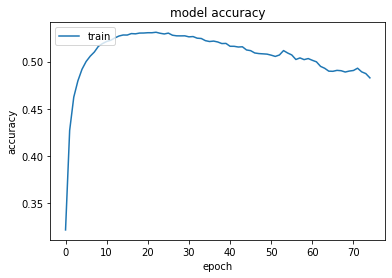

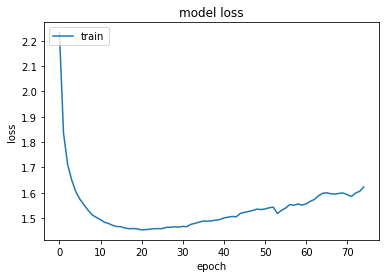

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
for temp in temperatures:
    print(f"MODEL_LETTERS_FINAL {temp} temperature prediction")
    print(predict(model, s_dict, "Litwo ojczyzno moja ty jestes jak zdrowie", max_p_len=1000, seq_len=seq_len, temperature=temp))

MODEL_LETTERS_FINAL 0.1 temperature prediction


<ipython-input-6-c7906edc74ed>:24: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature



W polowanie sie za nim sie za niebie w polowanie
Tak pod koncu w polowanie powiadal
Tak stal z powiesci pod strzelcy pod kapieli  Tadeusz pod konie po konie
W polowania z wielkiej za nim sie za przyszli sie w stolem
Tak sie z powiesci powiescia w polowania
Tak pod koniec w strzelcy pod koncu pod strony
W strzelcy sie za niebo powiedziac ze sie za powiescia
I z powiesci pod starych za nim sie za powiescie
I powiedzial ze sie z powiesci z soba po konie
Podkomorzy za niej sie pod starych sie za powiecie
I z powiesci z powiesci pod strzelcy sie zabawic
Tak w polowanie za nim sie za stol sie za stolem
I z powiesci powiescia sie za niebie za stolem
I pod stary pod stary w strony i zasie
Tak pod koncu w strzelcy pod stary pod konie
W polowania sie w strzelcy pod stary i zamkiem
I powiedzial ze sie za miejsce w koncu powieki
W powiesci pod strony w polowanie sie za powieki
W polowania strzelcow sie za nim pod nim strony
Podkomorzy sie z polowania strzelcow sie zalosnie
I 
MODEL_LETTERS_FINAL 

Jak widzimy, duza ilosc danych sprawiła, że model nie osiągnął nawet 55% accuracy, a dłuższe uczenie jedynie sprawiło, że accuracy spadło do ~40%. Nauczymy na nieco mniejszych danych i zmniejszmy ilość epok.

In [50]:
def scheduler(epoch, lr):
    if epoch<=15:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [51]:
CORPUS_SIZE = 160000
EPOCHS = 100
seq_len = 50
temperatures = [0.1, 0.25, 0.5, 0.75, 1.0, 1.33]

raw_corpus = get_corpus(CORPUS_SIZE) 
raw_corpus = ''.join([i for i in raw_corpus if i.isalpha() or i in [' ','\n','\r']]) 
raw_corpus = unidecode.unidecode(raw_corpus)

print(raw_corpus)

s_dict = get_symbol_dict(corpus=raw_corpus)
translated_corpus = translate(raw_corpus,s_dict)

net_in,net_out = process_to_sequential(translated_corpus, past_steps=seq_len)
net_in = np.reshape(net_in, (len(net_in),seq_len,1))
net_out = np_utils.to_categorical(net_out)

filepath = f"models/model_2_last.hdf5"

checkpoint = ModelCheckpoint(
filepath, monitor='loss', 
verbose=0,        
save_best_only=True,        
mode='min',
period=10
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

model_2 = get_lstm_model(net_in.shape,len(s_dict),units=512, dropout=0.3)
history_2 = model_2.fit(net_in, net_out, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,callbacks=[checkpoint, lr_scheduler])

data_pl\pan_tadeusz.txt
Adam Mickiewicz

Pan Tadeusz czyli ostatni zajazd na Litwie

Ksiega pierwsza

Gospodarstwo

Powrot panicza  Spotkanie sie pierwsze w pokoiku drugie u stolu  Wazna Sedziego nauka o grzecznosci  Podkomorzego uwagi polityczne nad modami  Poczatek sporu o Kusego i Sokola  Zale Wojskiego  Ostatni Wozny Trybunalu  Rzut oka na owczesny stan polityczny Litwy i Europy

    Litwo Ojczyzno moja ty jestes jak zdrowie
Ile cie trzeba cenic ten tylko sie dowie
Kto cie stracil Dzis pieknosc twa w calej ozdobie
Widze i opisuje bo tesknie po tobie

    Panno swieta co Jasnej bronisz Czestochowy
I w Ostrej swiecisz Bramie Ty co grod zamkowy
Nowogrodzki ochraniasz z jego wiernym ludem
Jak mnie dziecko do zdrowia powrocilas cudem
Gdy od placzacej matki pod Twoja opieke
Ofiarowany martwa podnioslem powieke
I zaraz moglem pieszo do Twych swiatyn progu
Isc za wrocone zycie podziekowac Bogu
Tak nas powrocisz cudem na Ojczyzny lono
Tymczasem przenos moja dusze uteskniona
Do tych pagorkow

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
4813/4813 [==============================] - 461s 92ms/step - loss: 2.5509 - accuracy: 0.2535
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
4813/4813 [==============================] - 441s 92ms/step - loss: 1.8928 - accuracy: 0.4098
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
4813/4813 [==============================] - 443s 92ms/step - loss: 1.7066 - accuracy: 0.4619
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
4813/4813 [==============================] - 440s 91ms/step - loss: 1.6144 - accuracy: 0.4893
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
4813/4813 [==============================] - 4217s 876ms/step - loss: 1.5455 - accuracy: 0.5082
Epoch 6/100

Epoch 00006: LearningRateSched

4813/4813 [==============================] - 447s 93ms/step - loss: 0.9400 - accuracy: 0.6868
Epoch 40/100

Epoch 00040: LearningRateScheduler reducing learning rate to tf.Tensor(0.00030119444, shape=(), dtype=float32).
4813/4813 [==============================] - 448s 93ms/step - loss: 0.9250 - accuracy: 0.6925s - loss: 0.9250 - accuracy: 0.
Epoch 41/100

Epoch 00041: LearningRateScheduler reducing learning rate to tf.Tensor(0.000286505, shape=(), dtype=float32).
4813/4813 [==============================] - 446s 93ms/step - loss: 0.9084 - accuracy: 0.6983
Epoch 42/100

Epoch 00042: LearningRateScheduler reducing learning rate to tf.Tensor(0.000272532, shape=(), dtype=float32).
4813/4813 [==============================] - 445s 92ms/step - loss: 0.8964 - accuracy: 0.7038
Epoch 43/100

Epoch 00043: LearningRateScheduler reducing learning rate to tf.Tensor(0.00025924045, shape=(), dtype=float32).
4813/4813 [==============================] - 445s 93ms/step - loss: 0.8842 - accuracy: 0.7057

4813/4813 [==============================] - 449s 93ms/step - loss: 0.5990 - accuracy: 0.8017
Epoch 76/100

Epoch 00076: LearningRateScheduler reducing learning rate to tf.Tensor(4.978715e-05, shape=(), dtype=float32).
4813/4813 [==============================] - 449s 93ms/step - loss: 0.5992 - accuracy: 0.8007
Epoch 77/100

Epoch 00077: LearningRateScheduler reducing learning rate to tf.Tensor(4.7359004e-05, shape=(), dtype=float32).
4813/4813 [==============================] - 457s 95ms/step - loss: 0.5946 - accuracy: 0.8029
Epoch 78/100

Epoch 00078: LearningRateScheduler reducing learning rate to tf.Tensor(4.504928e-05, shape=(), dtype=float32).
4813/4813 [==============================] - 451s 94ms/step - loss: 0.5855 - accuracy: 0.8055
Epoch 79/100

Epoch 00079: LearningRateScheduler reducing learning rate to tf.Tensor(4.2852203e-05, shape=(), dtype=float32).
4813/4813 [==============================] - 444s 92ms/step - loss: 0.5861 - accuracy: 0.8053
Epoch 80/100

Epoch 00080: L

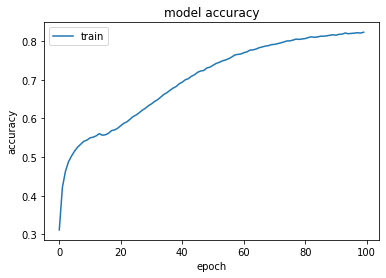

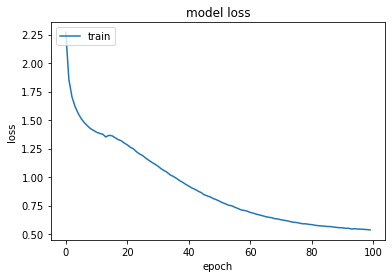

In [52]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
for temp in temperatures:
    print(f"MODEL_LETTERS_FINAL {temp} temperature prediction")
    print(predict(model_2, s_dict, "Litwo ojczyzno moja ty jestes jak zdrowie ", max_p_len=2000, seq_len=seq_len, temperature=temp))

MODEL_LETTERS_FINAL 0.1 temperature prediction


<ipython-input-6-c7906edc74ed>:24: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature



Ojczyzna nie przestawal i on zaczeto stali
Z drugiego nie podoba to mam wiec sie zrazu
Rozprawiali o flintach chartach i szarakach
Nie mogl uslyszec Sedzia tuz przy bernardynie
Reke jedna powiazane w powiecie wiecej
I do wielkiej przyszla urzadzac w koncu zatknieto
Ze tam podobne farsza jak wiadomo czeka
I po ciemnosci starzy sie przez zagralo
Tak skrzydli i z poslancu do swej ostepu
Czy zaczely wszyscy Soplicowie do stola
Przystawiwszy imbryki odwiedza mlodziez

    Tadeusz z Telimena pomiedzy izbami
Stojac we drzwiach na progu sercu tak sie zmija
A co fuzyjka moja niewielka ptaszyna
A na koniec po wielkim domu i oblokiem
Jak wiankiem zapewne w pole i w podarunku
Tu wszedlszy starzec w stolicy stryjama sie kryje
Odslaniajac ramiona i labedzia czyna
Na pamiatke rozumna zywa jak wiadomosc
Wojski z Woznym Protazym ze swiecami w pokoiku
Podniosl ku niebu oczy cicho przez okno
Czesto chlopi talara w przyklad pod Napoleonem
Przy miejsce na swiecie jak wiesc gminna wyprawe
I pod strzecha zm


Odparl Wilbik  To przeciez wyrownych maruchow
Wiwat u Hrabiego na ganku prosze lasy

    Goscie a tu przyszla jaki lowczy dluzszymi
Ktore mial wielka krew broniacych bardzo kruczy
I dziewcze koszyki wszyscy Widac ze lasku
Ale gdyby oczu nie bylo rzucali zwierze
A ktoz wejrzenie moja cale jak w lekki
W ktorej nawiedzic od Zydow byl peorami w
Tlumaczono oblawa sie zagadkami wzniesci
A na uprosto lisciem wygodna dla zabierac
Szlachty i tez innych rozpacza ja Robaka
Ustapi i zielony pawie sie w lowowym
Ujadajac cwalem do smierci potem serce

    Tu smiech i barbu staja mowil i skore lada
Z jej wypadlo w jednej domu zalamie oczu
Hrabia tysuwal i kcial wysmukla porwalem
Slychac podnioslszy roznych niegdys zawiasta
Przypatrzcie sie lecz nas wszystkich pom odzierano
O tym sam macholkiem a sukienka nadzie
Jak wiesc z pol rozmowa Sokol i kilkakrzynow

    Odwrociwszy sie ale je bez kun pielano
Juz upowszechnie prosto panstwo do malinie
My parkan od samotny wzdychal punskim spalku malych
Ojciec 

Widać, że czasem model stara się stworzyć poprawny szyk zdania: "Tadeusz spojrzal nagle uslyszal nad strumieniu"

# Wnioski

Ostateczny model generuje tekst, który przypomina materiał źródłowy. Brakuje mu jednak struktury i rymów, których można się było spodziewać. Zamiast generowania tekstu, podobna sieć neuronowa mogła by wspomóc pracę w szeroko pojętym pisaniu (podpowiadanie słów, czy znaków) i takie zastosowanie byłoby bardziej praktyczne niż obecne wykorzystanie.
